# Sheet 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import pyplot as plt
%matplotlib inline

## 1 Principal Component Analysis
### (a)

In [3]:
# TODO: implement PCA (fill in the blanks in the function below)

def pca(data, n_components=None):
    """
    Principal Component Analysis on a p x N data matrix.
    
    Parameters
    ----------
    data : np.ndarray
        Data matrix of shape (p, N).
    n_components : int, optional
        Number of requested components. By default returns all components.
        
    Returns
    -------
    np.ndarray, np.ndarray
        the pca components (shape (n_components, p)) and the projection (shape (n_components, N))

    """
    # set n_components to p by default
    n_components = data.shape[0] if n_components is None else n_components
    assert n_components <= data.shape[0], f"Got n_components larger than dimensionality of data!"
    
    # center the data
    data = data - data.mean(axis = 1)[:,np.newaxis]
    
    # compute X times X transpose
    xxt = data.dot(data.T)
    
    # compute the eigenvectors and eigenvalues
    eig_val, eig_vec = np.linalg.eig(xxt)

    # sort the eigenvectors by eigenvalue and take the n_components largest ones
    sorted = np.argsort(eig_val)[::-1]

    eig_vec = eig_vec[sorted, :]
    eig_val = eig_val[sorted]

    components = eig_vec[:n_components]
    
    # compute X_projected, the projection of the data to the components
    X_projected = components.dot(data)

    return components, X_projected  # return the n_components first components and the pca projection of the data


In [4]:
# Example data to test your implementation 
# All the asserts on the bottom should go through if your implementation is correct

data = np.array([
    [ 1,  0,  0, -1,  0,  0],
    [ 0,  3,  0,  0, -3,  0],
    [ 0,  0,  5,  0,  0, -5]
], dtype=np.float32)

# add a random offset to all samples. it should not affect the results
data += np.random.randn(data.shape[0], 1)

n_components = 2
components, projection = pca(data, n_components=n_components)  # apply your implementation

# the correct results are known (up to some signs)
true_components = np.array([[0, 0, 1], [0, 1, 0]], dtype=np.float32)
true_projection = np.array([
    [ 0,  0,  5,  0,  0, -5],
    [ 0,  3,  0,  0, -3,  0]
], dtype=np.float32)

# check that components match, up to sign
assert isinstance(components, np.ndarray), f'Expected components to be numpy array but got {type(components)}'
assert components.shape == true_components.shape, f'{components.shape}!={true_components.shape}'
assert np.allclose(np.abs(components * true_components).sum(1), np.ones(n_components)), f'Components not matching'

# check that projections agree, taking into account potentially flipped components
assert isinstance(projection, np.ndarray), f'Expected projection to be numpy array but got {type(projection)}'
assert projection.shape == (n_components, data.shape[1]), f'Incorrect shape of projection: Expected {(n_components, data.shape[1])}, got {projection.shape}'
assert np.allclose(projection, true_projection * (components * true_components).sum(1, keepdims=True), atol=1e-6), f'Projections not matching'

print('Test successful!')

Test successful!


### (b)

Load the data (it is a subset of the data at https://opendata.cern.ch/record/4910#)

In [8]:
features = np.load('data/dijet_features.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

print(f'{features.shape=}, {labels.shape=}')  # print the shapes

# TODO: print how many samples of each class are present in the data (hint: numpy.unique)
_labels, _counts = np.unique(labels, return_counts = True)

for label, count in zip(_labels, _counts):
    print(f'Number of instaces with label {label}: {count}')

features.shape=(116, 2233), labels.shape=(2233,)
Number of instaces with label 0.0: 999
Number of instaces with label 1.0: 864
Number of instaces with label 2.0: 370


Normalize the data

In [70]:
# TODO: subtract the mean of each feature to center the data
features = features - features.mean(axis = 1)[:,np.newaxis]

# TODO: divide by the standard deviation of each feature to normalize the variance
features = features / features.std(axis = 1)[:,np.newaxis]

### (c)
Compute a 2D PCA projection and make a scatterplot of the result, once without color, once coloring the dots by label

In [42]:
# TODO: apply PCA as implemented in (a)
components, projected_features = pca(data=features, n_components=2)

In [53]:
'''The pca returns projected features with an imaginary value. 
As we can see, this value is very small (at least for the first two components) in magnitude'''
np.abs(np.imag(projected_features)).max()

5.267533154478281e-09

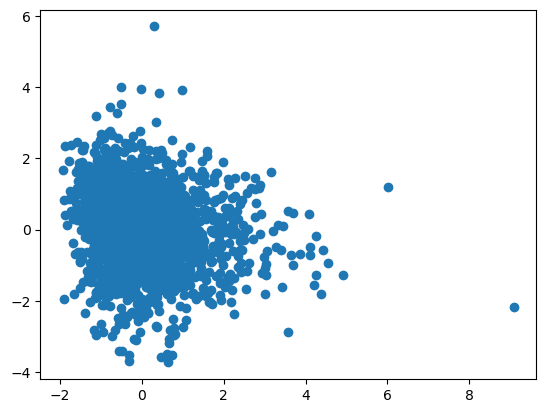

In [54]:
# TODO: make a scatterplot of the PCA projection
plt.scatter(*np.real(projected_features))

Text(0, 0.5, 'pc 2')

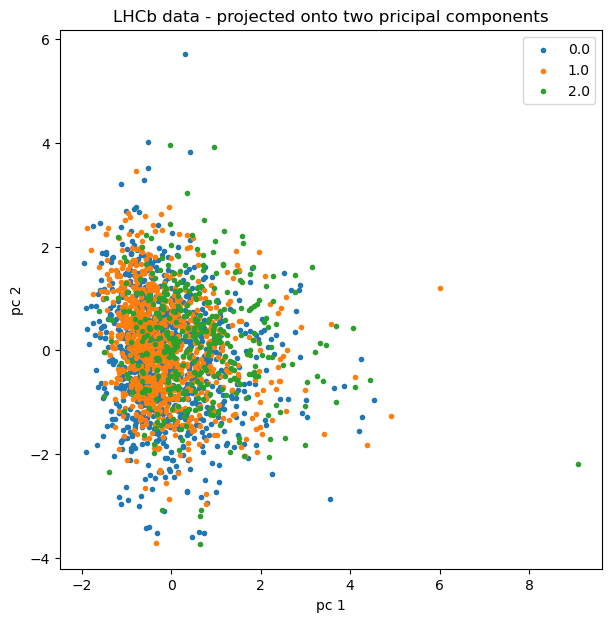

In [66]:
# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels)
plt.figure(figsize = (7,7))
plt.title('LHCb data - projected onto two pricipal components')

for label in np.unique(labels):
    plt.scatter(*np.real(projected_features[:,labels == label]), marker = '.', label = label)

plt.legend()

plt.xlabel('pc 1')
plt.ylabel('pc 2')

## 2 Nonlinear Dimension Reduction

In [67]:
import umap  # import umap-learn, see https://umap-learn.readthedocs.io/

In [84]:
# if you have not done 1(b) yet, you can load the normalized features directly:
features = np.load('data/dijet_features_normalized.npy')
labels = np.load('data/dijet_labels.npy')
label_names = ['b', 'c', 'q']  # bottom, charm or light quarks

### (a)

In [89]:
# TODO: Apply umap on the normalized jet features from excercise 1. It will take a couple of seconds.
# note: umap uses a different convention regarding the feature- and sample dimension, N x p instead of p x N!
reducer = umap.UMAP()

embedding = reducer.fit_transform(features.T)

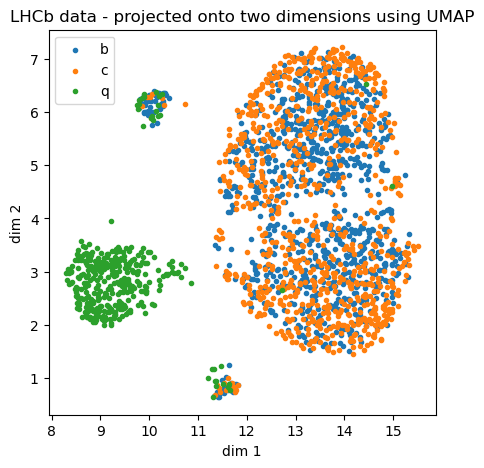

In [99]:
# TODO: make a scatterplot of the UMAP projection
#plt.figure()
#plt.scatter(embedding[:,0], embedding[:,1])

# TODO: make a scatterplot, coloring the dots by their label and including a legend with the label names
# (hint: one way is to call plt.scatter once for each of the three possible labels)

def plot_umap(embedding):
    plt.figure(figsize = (5,5))
    plt.title('LHCb data - projected onto two dimensions using UMAP')

    for label in np.unique(labels):
        plt.scatter(*embedding.T[:,labels == label], marker = '.', 
                    label = dict(zip([0.0, 1.0, 2.0], label_names))[label])

    plt.legend()

    plt.xlabel('dim 1')
    plt.ylabel('dim 2')

    plt.show()

plot_umap(embedding)

### (b)

Starting with 2


/home/paul_zuern/miniconda3/envs/mlph/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/paul_zuern/miniconda3/envs/mlph/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Starting with 4
Starting with 8
Starting with 15
Starting with 30
Starting with 60
Starting with 100


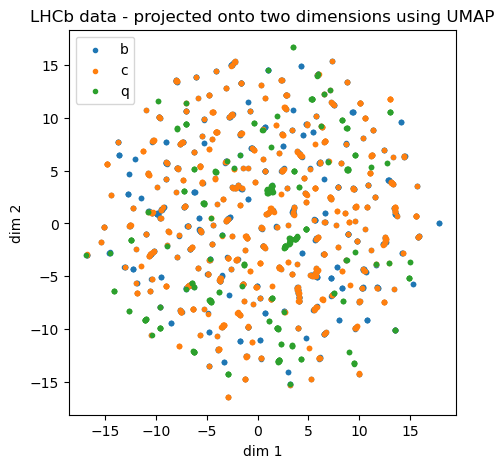

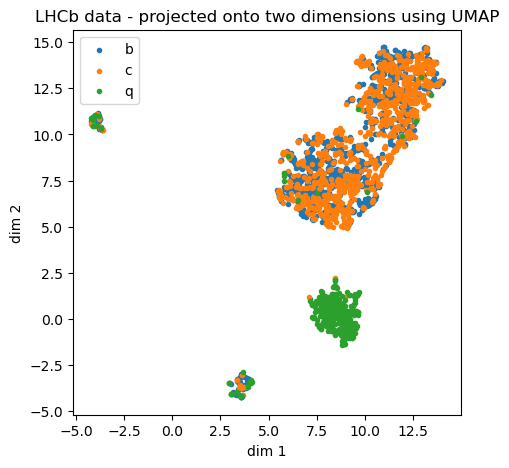

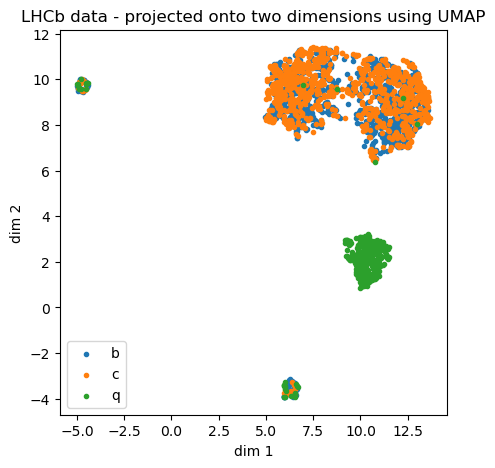

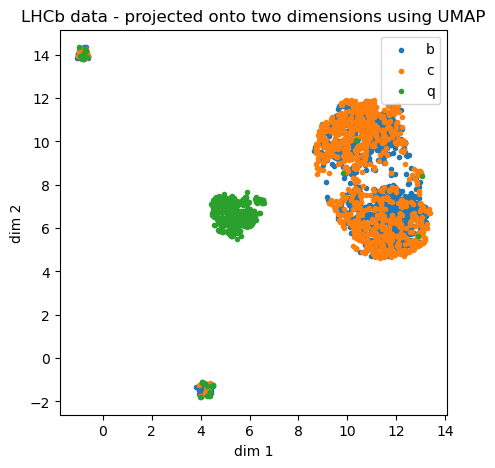

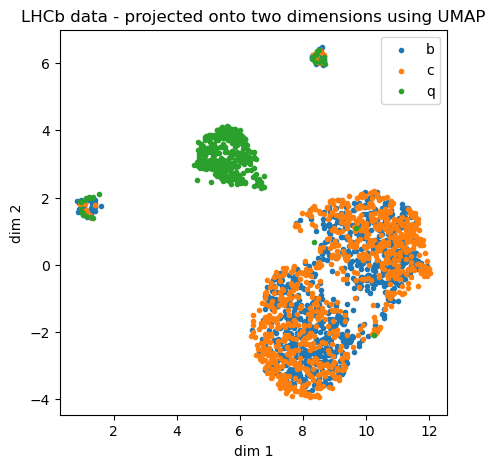

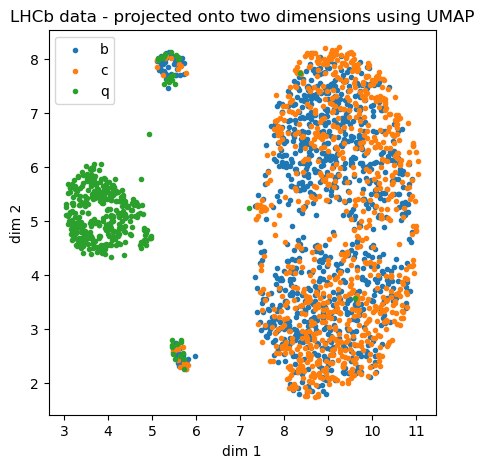

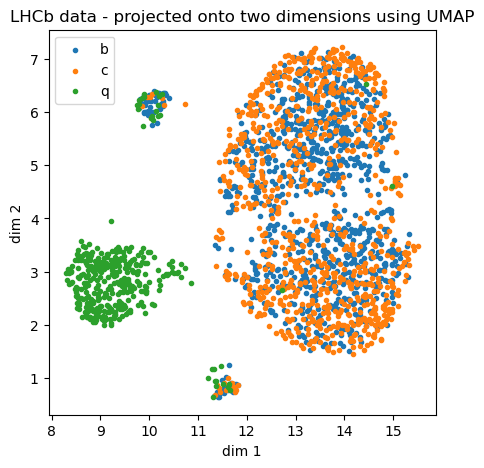

In [98]:
for n_neighbors in (2, 4, 8, 15, 30, 60, 100):
    # TODO: repeat the above, varying the n_neighbors parameter of UMAP
    print(f'Number of neighbours used in UMAP {n_neighbors}')

    reducer = umap.UMAP(n_neighbors=n_neighbors)
    
    embedding = reducer.fit_transform(features.T)

    plot_umap(embedding)

### (c)

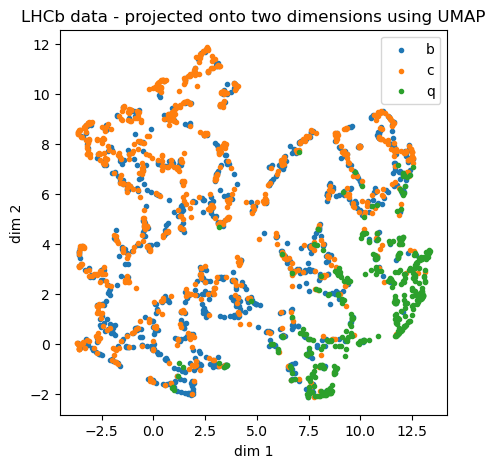

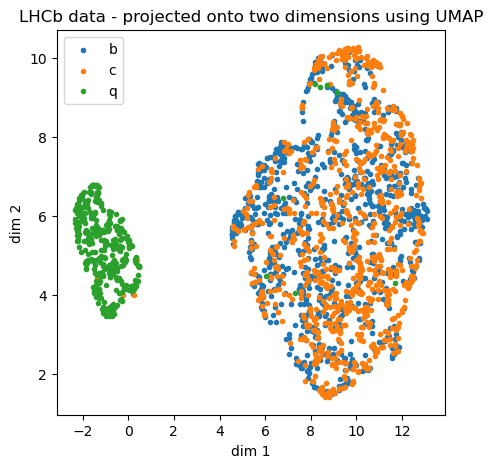

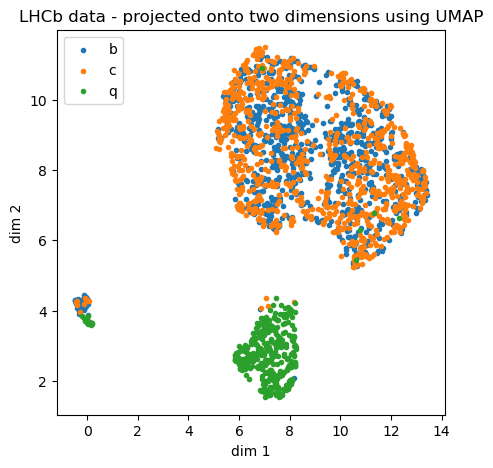

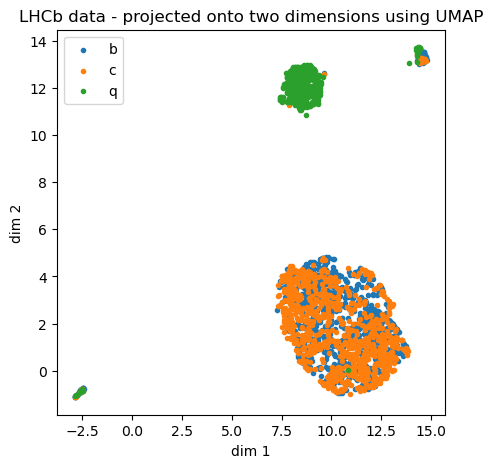

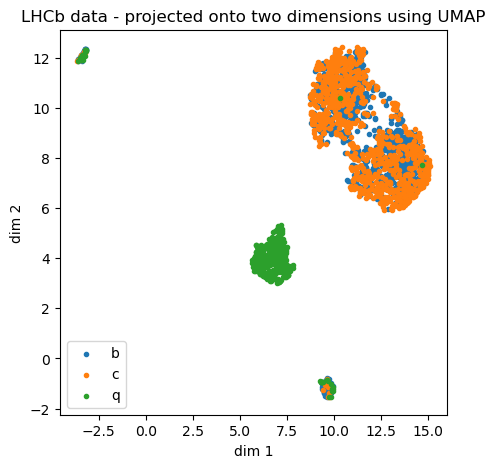

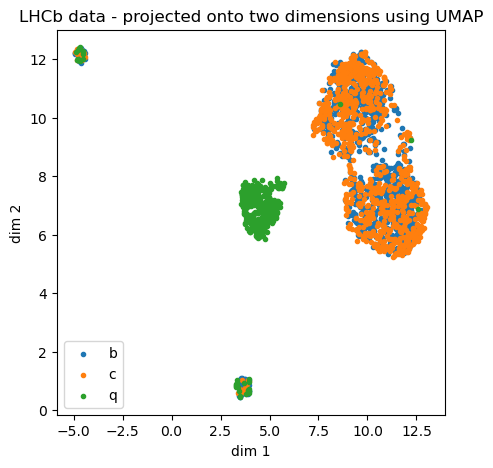

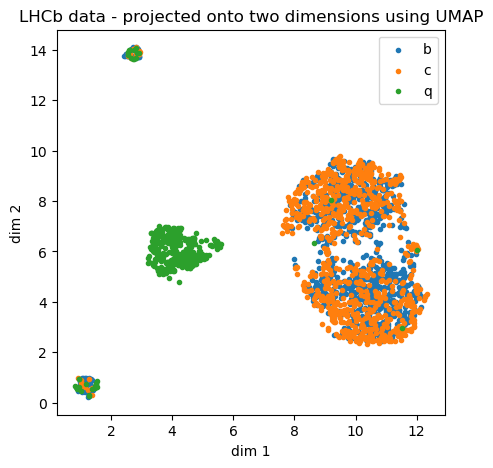

In [101]:
from sklearn.decomposition import PCA as skPCA

for n_components in (2, 4, 8, 16, 32, 64, len(features)):
    # TODO: project to the n-components first principal components 
    #       (use your implementation from ex. 1 or PCA from scikit-learn)
    PCA = skPCA(n_components=n_components)
    
    projected_features = PCA.fit_transform(features.T)

    # TODO: apply UMAP to get from n_components to just two dimensions
    reducer = umap.UMAP()

    embedding = reducer.fit_transform(projected_features)

    # TODO: again, make scatterplots as before
    plot_umap(embedding)